# Sound <> Color

Lewis Guignard

MUS199B Spring 2024 Final Project


## Code: `github.com/lewis1286/mus199b`

# Imports, globals

!! use conda env `music_3_6`

In [ ]:
import numpy as np
import pandas as pd

from bokeh.plotting import figure, output_notebook, show

from synthesizer import Player, Synthesizer, Waveform

output_notebook()

In [ ]:
# source: https://muted.io/note-frequencies/
notes = [
    {'name': 'f#', 'note_frequency_Hz': 185},
    {'name': 'g',  'note_frequency_Hz': 196},
    {'name': 'g#', 'note_frequency_Hz': 207.65},
    {'name': 'a',  'note_frequency_Hz': 220},
    {'name': 'a#', 'note_frequency_Hz': 233.08},
    {'name': 'b',  'note_frequency_Hz': 246.94},
    {'name': 'c',  'note_frequency_Hz': 261.63},
    {'name': 'c#', 'note_frequency_Hz': 277.18},
    {'name': 'd',  'note_frequency_Hz': 293.66},
    {'name': 'd#', 'note_frequency_Hz': 311.13},
    {'name': 'e',  'note_frequency_Hz': 329.63},
    {'name': 'f',  'note_frequency_Hz': 349.23},
]

In [ ]:
results_cols = [
    'Timestamp',
    'Experiment 1: Affinity',
    'Experiment 1: enter the first word that comes to mind',
    'Experiment 2: Affinity',
    'Experiment 2: enter the first word that comes to mind',
    'Experiment 3: Affinity',
    'Experiment 3: enter the first word that comes to mind',
    'Experiment 4: Affinity',
    'Experiment 4: enter the first word that comes to mind',
    'Experiment 5: Affinity',
    'Experiment 5: enter the first word that comes to mind',
    'Experiment 6: Affinity',
    'Experiment 6: enter the first word that comes to mind',
    'Experiment 7: Affinity',
    'Experiment 7: enter the first word that comes to mind',
    'Experiment 8: Affinity',
    'Experiment 8: enter the first word that comes to mind',
]

# Methods

In [ ]:
def get_light_frequency(note, octaves=41):
    light_frequency = note * pow(2, octaves) * 1e-12
    # print(f"name: {note['name']}\n\t light_frequency: {round(light_frequency, 2)}")
    return light_frequency

In [ ]:
# Thanks: https://stackoverflow.com/questions/44959955/matplotlib-color-under-curve-based-on-spectral-color

def frequency_to_wavelength(frequency):
    """
    converts a frequency (in THz) to wavelength (in nm)
    input:
        frequency (THz)
    output:
        wavelength (nm)
    """
    c = 299792458 # m/s
    wavelength = c / (frequency * 1e12) * 1e9
    return wavelength

def wavelength_to_rgb(wavelength, gamma=0.4):
    ''' taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python
    This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    scale = 255
    R *= scale
    G *= scale
    B *= scale
    return (R,G,B,A)


def make_fig(df, shuffle=False):
    df_fig = df.copy()
    if shuffle:
        df_fig = df_fig.sample(frac=1)
    df_fig['x'] = range(len(df_fig))
    p = figure(height=300)
    p.rect(x='x', y=1, width=1, height=1, color='color', source=df_fig)
    if not HIDE:
        p.text(
            x='x', y=1, text='name', 
            text_font_size='22px',
            text_color='black',
            # text_outline_color='white',
            text_font_style='bold',
            source=df_fig
        )
        # Hide axes
    p.xaxis.visible = False
    p.yaxis.visible = False
    
    # Hide gridlines
    p.xgrid.visible = False
    p.ygrid.visible = False
    
    # Hide the toolbar
    p.toolbar_location = None
    return p


def import_results():
    google_sheet_link = 'https://docs.google.com/spreadsheets/d/1N5VT62Tt-RufaE-_9krZu8HZ3mCEfgEkLmZuQfUxZX8/edit?usp=sharing&output=csv'
    df_results = pd.read_html(google_sheet_link)[0]

    # replace header w first row
    new_header = df_results.iloc[0] #grab the first row for the header
    df_results = df_results[1:] #take the data less the header row
    df_results.columns = new_header #set the header row as the df header
    # print(df_results.columns)

    df_results.dropna(subset=['Timestamp'], inplace=True)
    df_results = df_results[results_cols]

    for col in df_results.columns:
        if 'Affinity' in col:
            df_results[col] = df_results[col].astype(float)
    print('done!')
    return df_results

In [ ]:
def get_color(frequency):
    """
    return RGBA for given light frequency (in THz)
    """
    return wavelength_to_rgb(frequency_to_wavelength(frequency))


def plot_affinity(col):
    # Plot results
    x = list(range(1,11))

    # col = 
    counts = pd.DataFrame(df_results[col]).value_counts()

    counts.index = counts.index.get_level_values(0)
    counts = counts.to_dict()
    y = [0] * 10

    for count in counts.keys():
        y[int(count)-1] = counts[count]

    p = figure(title=col, height=200)
    p.vbar(x=x, top=y, width=0.9)
    # Hide the toolbar
    p.toolbar_location = None

    return p


def show_experiment(experiment):
    if not HIDE: 
        print(experiment['name'])
    show(make_fig(df.loc[df['name'].isin(experiment['notes'])]), shuffle=True)
    if not HIDE:
        # Show voting results:
        experiment_no = experiment['experiment']
        affinity_col = f'Experiment {experiment_no}: Affinity'
        word_col = f'Experiment {experiment_no}: enter the first word that comes to mind'
        
        # make voting fig
        show(plot_affinity(affinity_col))
        
        # print words used
        print(' --------   Words  Entered   -------------')
        print(' '.join(list(df_results[word_col])))
        # TODO: could cluster these words in semantic space
        print(' ----------------------------------------- ')
        
        player = Player()
        player.open_stream()
        synthesizer = Synthesizer(osc1_waveform=Waveform.sine, osc1_volume=1.0, use_osc2=False)
        chord = list(df.loc[df['name'].isin(experiment['notes']), 'note_frequency_Hz'])
        player.play_wave(synthesizer.generate_chord(chord, 3.0))

In [ ]:

df = pd.DataFrame(notes)
df['light_frequency_THz'] = df['note_frequency_Hz'].apply(get_light_frequency)
df['color'] = df['light_frequency_THz'].apply(get_color)
df['idx'] = range(len(df))

In [ ]:
# make experiments
experiments = [
    {
        'experiment': 1,
        'name': 'D# Major',
        'notes': ['d#', 'g', 'a#'],
    },
    {
        'experiment': 2,
        'name': 'A Minor',
        'notes': ['a', 'c', 'e'],
    },
    {
        'experiment': 3,
        'name': "random 3 notes (a)",
        'notes': ['a#', 'd', 'g#'],
    },  
    {
        'experiment': 4,
        'name': 'C dominant 7th',
        'notes': ['c', 'e', 'g', 'a#'],
    },
    {
        'experiment': 5,
        'name': "random 3 notes (b)",
        'notes': ['a#', 'f#', 'a'],
    },   
    {
        'experiment': 6,
        'name': "Tritone (devil's chord)",
        'notes': ['f', 'b'],
    },    
    {
        'experiment': 7,
        'name': "G# 5th",
        'notes': ['g#', 'd#'],
    },   
    {
        'experiment': 8,
        'name': "C# Third",
        'notes': ['c#', 'f'],
    },   
]

# Presentation

## Theory:

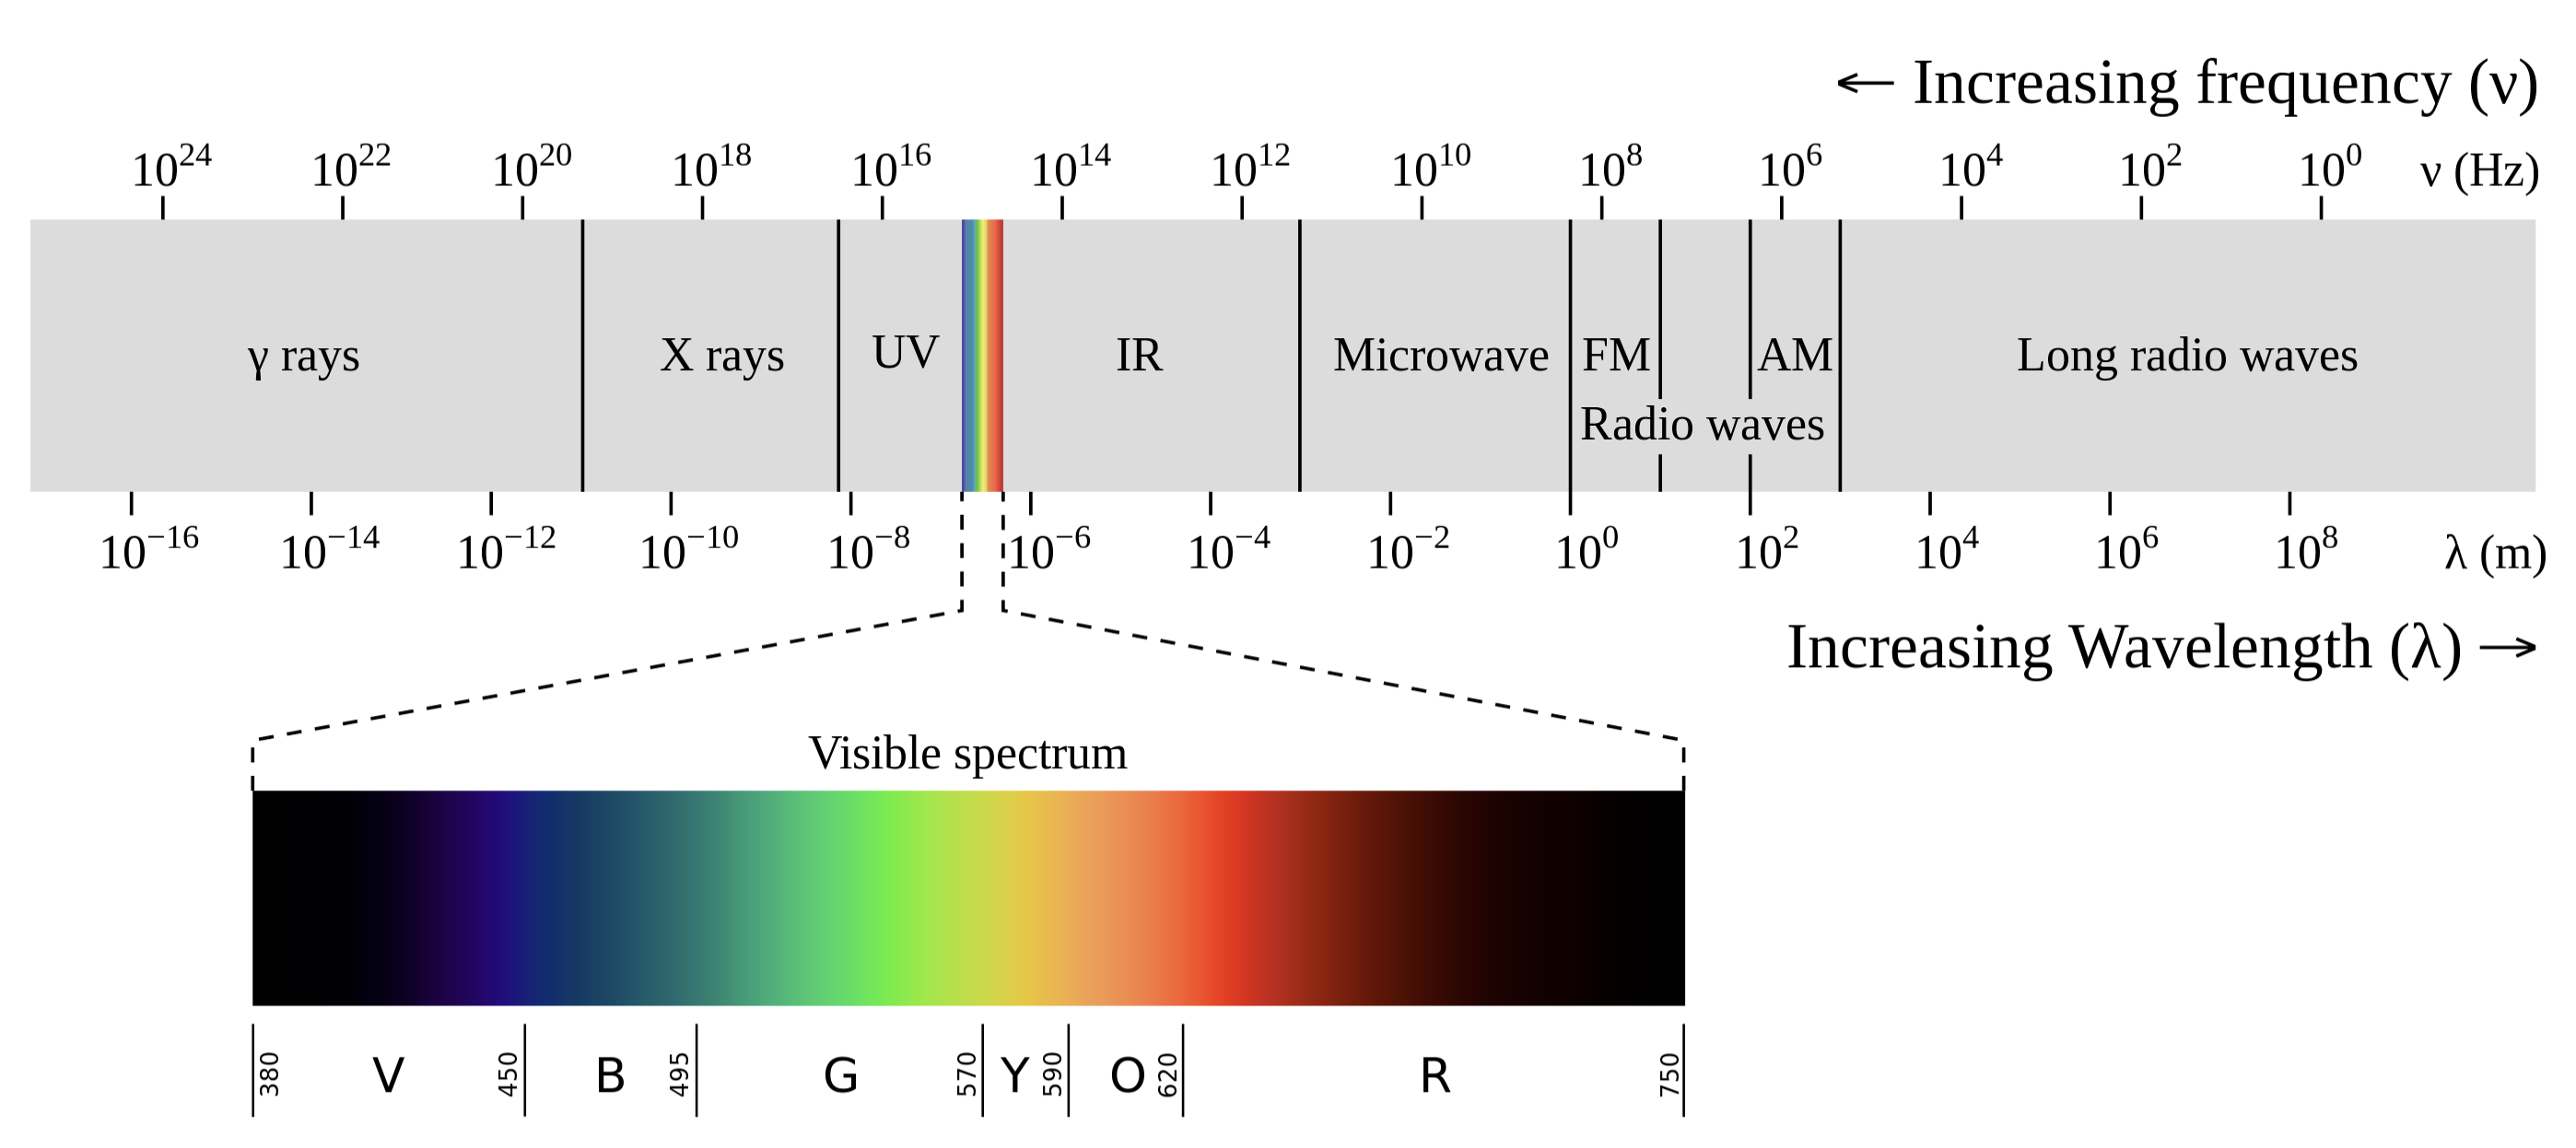

# [source](https://en.wikipedia.org/wiki/Light)

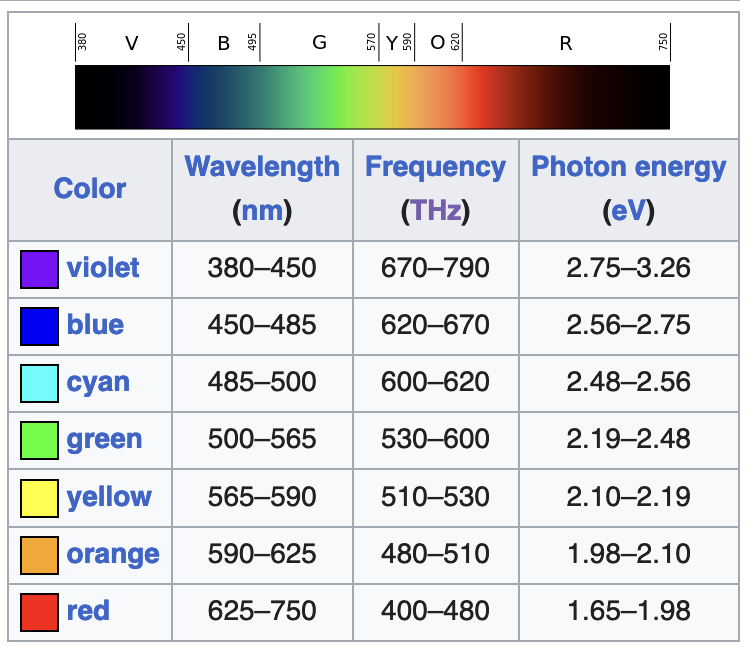

# [source](https://en.wikipedia.org/wiki/Visible_spectrum)

In [ ]:
root = 440
octave_no = 4


for i in range(41):
    print(f'A{octave_no + i}: \t{root * pow(2, i)} Hz')

# Notes:
# human hearing stops after A9
# sound itself stops after 'around' A27
# A44 lands in the frequency of visible light

# Question: Do pleasing chords correlate to pleasing color combinations?

## Survey:        `bit.ly/mus199b_final`

## Instructions:

Each color combination in an experiment may or may not be a 'chord' or popular interval.  Choose how much you 'like' the color combination and the first word that pops into mind when seeing it.  

!!! Please try not to base your answer on any individual color, but on the **relationships of the colors** to each other.

!!! Please try to **be silent** and not share your opinions during the experiment, so that each participant's answers will be independent.

In [ ]:
HIDE = True

In [ ]:
show(make_fig(df))

## Experiment 1

In [ ]:
show_experiment(experiments[0])

## Experiment 2

In [ ]:
show_experiment(experiments[1])

## Experiment 3

In [ ]:
show_experiment(experiments[2])

## Experiment 4

In [ ]:
show_experiment(experiments[3])

## Experiment 5

In [ ]:
show_experiment(experiments[4])

## Experiment 6

In [ ]:
show_experiment(experiments[5])

## Experiment 7

In [ ]:
show_experiment(experiments[6])

## Experiment 8

In [ ]:
show_experiment(experiments[7])

# Results

In [ ]:
df_results = import_results()